In [4]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error, mean_squared_error
import pmdarima as pm

plt.rcParams["figure.figsize"] = (11,5)

In [5]:
csv_path = "C:\\Users\\ACER\\Downloads\\infosys dataset\\time_series_forecast\\data\\crop_yield_dataset.csv"
df = pd.read_csv(csv_path)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Shape: (36520, 12)
Columns: ['Date', 'Crop_Type', 'Soil_Type', 'Soil_pH', 'Temperature', 'Humidity', 'Wind_Speed', 'N', 'P', 'K', 'Crop_Yield', 'Soil_Quality']


,Date,Crop_Type,Soil_Type,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
0,2014-01-01,Wheat,Peaty,5.50,9.440599,80.000000,10.956707,60.5,45.0,31.5,0.000000,22.833333
1,2014-01-01,Corn,Loamy,6.50,20.052576,79.947424,8.591577,84.0,66.0,50.0,104.871310,66.666667
2,2014-01-01,Rice,Peaty,5.50,12.143099,80.000000,7.227751,71.5,54.0,38.5,0.000000,27.333333
3,2014-01-01,Barley,Sandy,6.75,19.751848,80.000000,2.682683,50.0,40.0,30.0,58.939796,35.000000
4,2014-01-01,Soybean,Peaty,5.50,16.110395,80.000000,7.696070,49.5,45.0,38.5,32.970413,22.166667


In [6]:
df.columns = df.columns.str.strip()  
date_col = "Date"

df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.dropna(subset=[date_col])
df = df.set_index(date_col).sort_index()

print("Index start:", df.index.min())
print("Index end:", df.index.max())
print("Frequency detected:", pd.infer_freq(df.index))

Index start: 2014-01-01 00:00:00
Index end: 2023-12-31 00:00:00
Frequency detected: None


In [7]:
numeric_df = df.select_dtypes(include="number")
df_daily = numeric_df.groupby(df.index).mean()

print("After aggregation:", df_daily.shape)
df_daily.head()

After aggregation: (3652, 9)


,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
Date,,,,,,,,,
2014-01-01,6.275,15.994309,79.994742,8.163837,64.55,51.60,40.50,37.073799,35.920833
2014-01-02,6.575,15.639907,79.998234,9.669001,67.00,54.05,43.15,34.636737,32.750000
2014-01-03,6.450,15.156596,79.028168,11.052915,66.50,53.30,42.35,22.107670,41.579167
2014-01-04,6.950,15.026332,79.479529,10.162655,68.70,55.80,44.75,28.197627,40.587500
2014-01-05,6.400,13.828252,80.000000,10.523809,68.45,55.65,45.00,26.062550,51.362500


In [8]:
def infer_regular_freq(idx):
    f = pd.infer_freq(idx)
    if f: return f
    diffs = idx.to_series().diff().dropna()
    if len(diffs)==0: return None
    med = diffs.median().days
    if med >= 300: return "YS"
    if 25 <= med <= 35: return "MS"
    if 6 <= med <= 8: return "W"
    if med == 1: return "D"
    return None

freq = infer_regular_freq(df_daily.index)
if freq is None:
    freq = "YS"  # fallback yearly start
print("Using frequency:", freq)

new_idx = pd.date_range(start=df_daily.index.min(), end=df_daily.index.max(), freq=freq)
df_reg = df_daily.reindex(new_idx)

Using frequency: D


NaNs after fill: 0


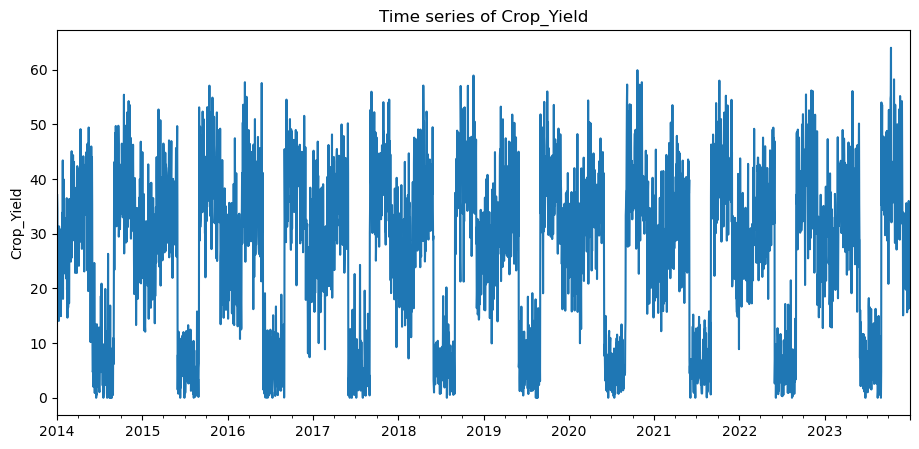

In [9]:
target_col = "Crop_Yield"
ts = df_reg[target_col].interpolate(method="time").ffill().bfill()

print("NaNs after fill:", ts.isna().sum())
ts.plot(title=f"Time series of {target_col}")
plt.ylabel(target_col)
plt.show()

In [10]:
def adf_test(series, name=""):
    res = adfuller(series.dropna())
    print(f"ADF test for {name}")
    print("Statistic:", res[0], "p-value:", res[1])
    return res[1]

pval = adf_test(ts, target_col)
d = 0 if pval < 0.05 else 1
print("Differencing order d =", d)

ADF test for Crop_Yield
Statistic: -6.236677196899408 p-value: 4.806731874424688e-08
Differencing order d = 0


In [11]:
auto = pm.auto_arima(ts, start_p=0, start_q=0,
                     max_p=5, max_q=5,
                     d=d, seasonal=False,
                     stepwise=True, trace=True)

print(auto.summary())
p, d, q = auto.order

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=35349.680, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=26868.195, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=32113.371, Time=0.44 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=26133.984, Time=0.23 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=25788.319, Time=0.30 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=25580.045, Time=1.39 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=25585.147, Time=1.30 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=25582.036, Time=1.68 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=25580.093, Time=2.39 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=25579.611, Time=2.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=25585.015, Time=0.95 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=25579.973, Time=1.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=25584.105, Time=0.36 sec
 ARIMA(1,0,3)(0,0,0)[0]  

In [12]:
split = int(len(ts)*0.8)
train, test = ts.iloc[:split], ts.iloc[split:]

model = SARIMAX(train, order=(p,d,q),
                enforce_stationarity=False,
                enforce_invertibility=False)
res = model.fit(disp=False)

print(res.summary())

                               SARIMAX Results                                
Dep. Variable:             Crop_Yield   No. Observations:                 2921
Model:               SARIMAX(3, 0, 1)   Log Likelihood              -10202.626
Date:                Sun, 05 Oct 2025   AIC                          20415.252
Time:                        15:10:52   BIC                          20445.145
Sample:                    01-01-2014   HQIC                         20426.019
                         - 12-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9699      0.031     30.930      0.000       0.908       1.031
ar.L2         -0.0514      0.024     -2.147      0.032      -0.098      -0.004
ar.L3          0.0773      0.025      3.108      0.0

MAE: 21.79676953821751 RMSE: 25.930132288772494


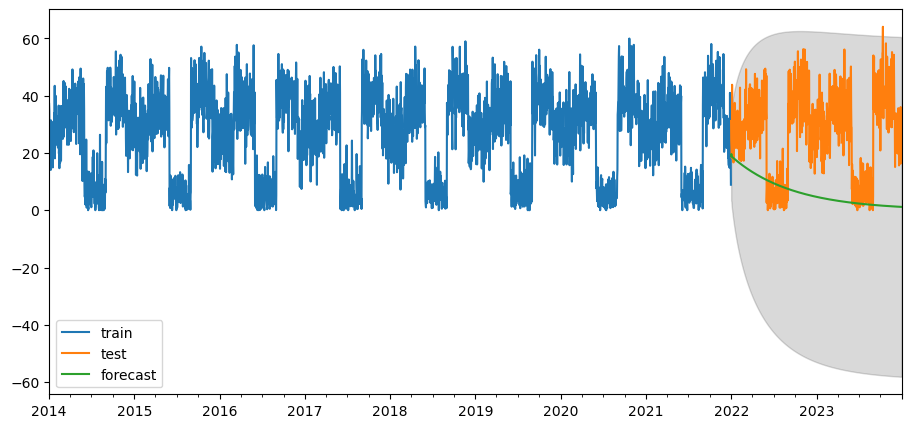

In [13]:
pred_obj = res.get_forecast(steps=len(test))
pred = pred_obj.predicted_mean
pred_ci = pred_obj.conf_int()

mae = mean_absolute_error(test, pred)
rmse = mean_squared_error(test, pred, squared=False)
print("MAE:", mae, "RMSE:", rmse)

ax = train.plot(label="train")
test.plot(ax=ax, label="test")
pred.plot(ax=ax, label="forecast")
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color="k", alpha=0.15)
ax.legend()
plt.show()

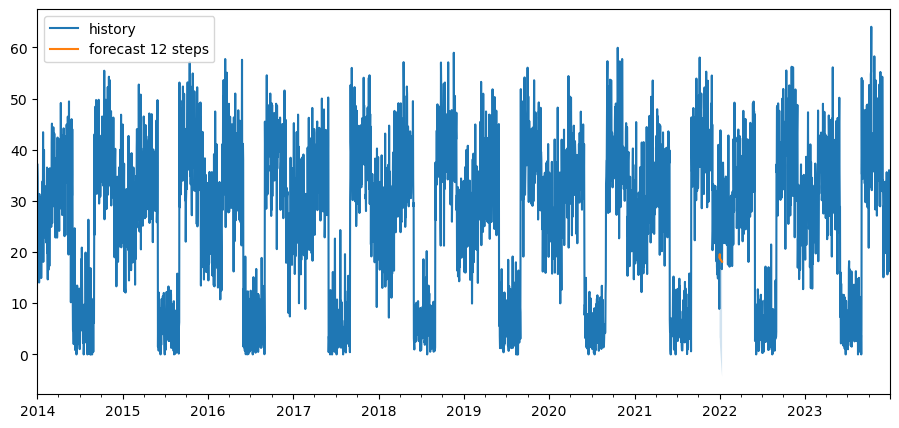

Future forecast values:
2021-12-31    18.963670
2022-01-01    19.585896
2022-01-02    18.708548
2022-01-03    18.604235
2022-01-04    18.596271
2022-01-05    18.526090
2022-01-06    18.450367
2022-01-07    18.379917
2022-01-08    18.310056
2022-01-09    18.240066
2022-01-10    18.170330
2022-01-11    18.100891
Freq: D, Name: predicted_mean, dtype: float64


In [14]:
future_steps = 12
fcast_obj = res.get_forecast(steps=future_steps)
fcast = fcast_obj.predicted_mean
fcast_ci = fcast_obj.conf_int()

ax = ts.plot(label="history")
fcast.plot(ax=ax, label=f"forecast {future_steps} steps")
ax.fill_between(fcast_ci.index, fcast_ci.iloc[:,0], fcast_ci.iloc[:,1], alpha=0.2)
ax.legend()
plt.show()

print("Future forecast values:")
print(fcast)

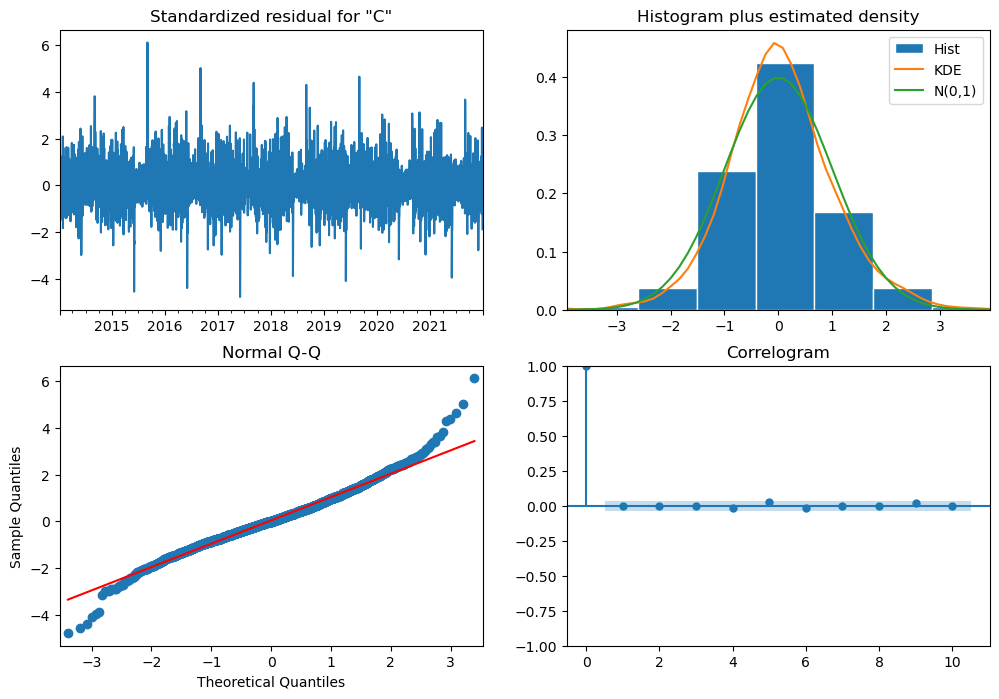

In [15]:
res.plot_diagnostics(figsize=(12,8))
plt.show()

In [16]:
print("MAE:", mae, "RMSE:", rmse)


MAE: 21.79676953821751 RMSE: 25.930132288772494


ADF Test for Crop_Yield
 Test Statistic : -6.236677196899408
 p-value        : 4.806731874424688e-08
 Critical Values:
    1%: -3.4321477795421935
    5%: -2.8623343588485692
    10%: -2.5671928493690377
 Series is Stationary


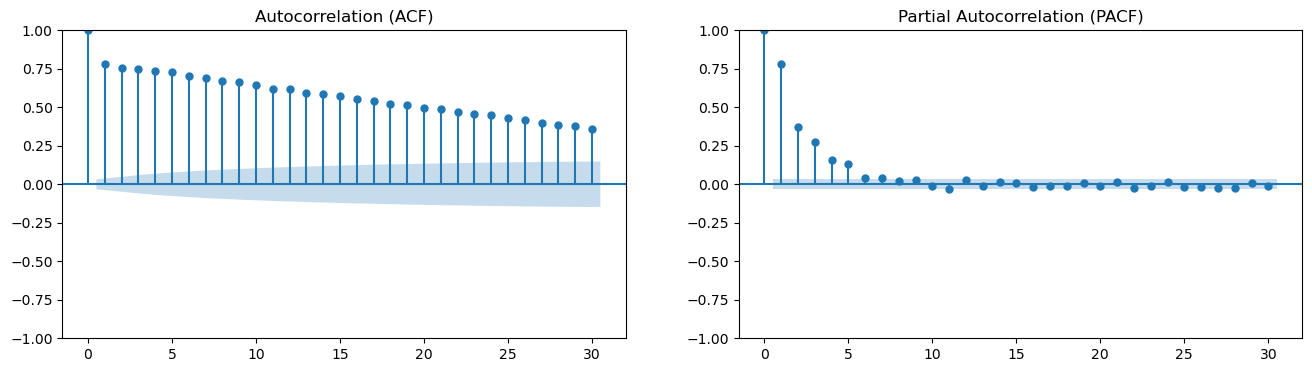

In [17]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# 1. ADF Test

def adf_test(series, name=""):
    result = adfuller(series.dropna())
    print(f"ADF Test for {name}")
    print(f" Test Statistic : {result[0]}")
    print(f" p-value        : {result[1]}")
    print(" Critical Values:")
    for key, value in result[4].items():
        print(f"    {key}: {value}")
    if result[1] <= 0.05:
        print(" Series is Stationary")
    else:
        print("Series is NOT Stationary")

adf_test(ts, "Crop_Yield")

# 2. ACF and PACF plots

fig, axes = plt.subplots(1, 2, figsize=(16,4))

plot_acf(ts.dropna(), lags=30, ax=axes[0])
axes[0].set_title("Autocorrelation (ACF)")

plot_pacf(ts.dropna(), lags=30, ax=axes[1], method="ywm")
axes[1].set_title("Partial Autocorrelation (PACF)")

plt.show()


                               SARIMAX Results                                
Dep. Variable:             Crop_Yield   No. Observations:                 2921
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -9224.780
Date:                Sun, 05 Oct 2025   AIC                          18465.561
Time:                        15:11:00   BIC                          18513.393
Sample:                    01-01-2014   HQIC                         18482.790
                         - 12-30-2021                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature     3.5050      0.138     25.413      0.000       3.235       3.775
Humidity        5.9110      0.176     33.598      0.000       5.566       6.256
N              -1.4034      0.983     -1.427    

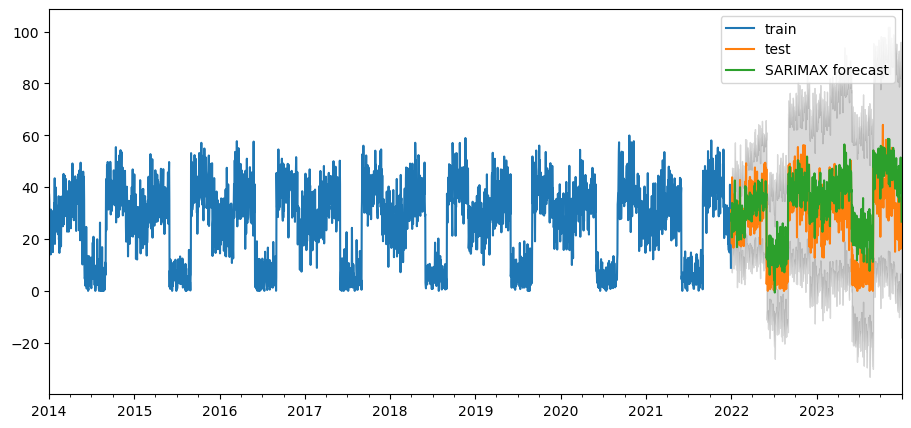

Future forecast values (multivariate SARIMAX):
2021-12-31    19.107360
2022-01-01    29.441838
2022-01-02    24.290656
2022-01-03    22.477588
2022-01-04    23.910518
2022-01-05    29.338938
2022-01-06    28.135152
2022-01-07    36.206500
2022-01-08    25.885124
2022-01-09    27.647653
2022-01-10    21.603392
2022-01-11    11.469174
Freq: D, Name: predicted_mean, dtype: float64


In [18]:
# Multivariate ARIMA (SARIMAX with exogenous features)


from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error


target_col = "Crop_Yield"

# exogenous features 
exog_cols = ["Temperature", "Humidity", "N", "P", "K"]

ts = df_reg[target_col].interpolate(method="time").ffill().bfill()
exog = df_reg[exog_cols].interpolate(method="time").ffill().bfill()

# align both
ts, exog = ts.align(exog, join="inner", axis=0)

# 2. Train/test split
split = int(len(ts) * 0.8)
train, test = ts.iloc[:split], ts.iloc[split:]
exog_train, exog_test = exog.iloc[:split], exog.iloc[split:]

# 3. Fit SARIMAX 
order = (1,0,1)  
model = SARIMAX(train, exog=exog_train,
                order=order, 
                enforce_stationarity=False, 
                enforce_invertibility=False)
res = model.fit(disp=False)

print(res.summary())

# 4. Forecast
n_steps = len(test)
pred_obj = res.get_forecast(steps=n_steps, exog=exog_test)
pred = pred_obj.predicted_mean
pred_ci = pred_obj.conf_int()

# 5. Evaluate
mae = mean_absolute_error(test, pred)
rmse = mean_squared_error(test, pred, squared=False)
print("Multivariate SARIMAX -> MAE:", mae, "RMSE:", rmse)

# 6. Plot
ax = train.plot(label="train")
test.plot(ax=ax, label="test")
pred.plot(ax=ax, label="SARIMAX forecast")
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color="k", alpha=0.15)
ax.legend()
plt.show()

# 7. Forecast future steps with exogenous data 

future_steps = 12
future_exog = exog.iloc[-future_steps:]  
fcast_obj = res.get_forecast(steps=future_steps, exog=future_exog)
fcast = fcast_obj.predicted_mean
fcast_ci = fcast_obj.conf_int()

print("Future forecast values (multivariate SARIMAX):")
print(fcast)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3945
[LightGBM] [Info] Number of data points in the train set: 2910, number of used features: 16
[LightGBM] [Info] Start training from score 26.820129


  File "c:\Users\ACER\anaconda3\envs\crop_forecast_clean\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\ACER\anaconda3\envs\crop_forecast_clean\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\ACER\anaconda3\envs\crop_forecast_clean\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\ACER\anaconda3\envs\crop_forecast_clean\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


SARIMAX -> MAE: 8.171, RMSE: 10.034
LightGBM -> MAE: 3.600, RMSE: 4.744
Ensemble -> MAE: 4.673, RMSE: 5.743


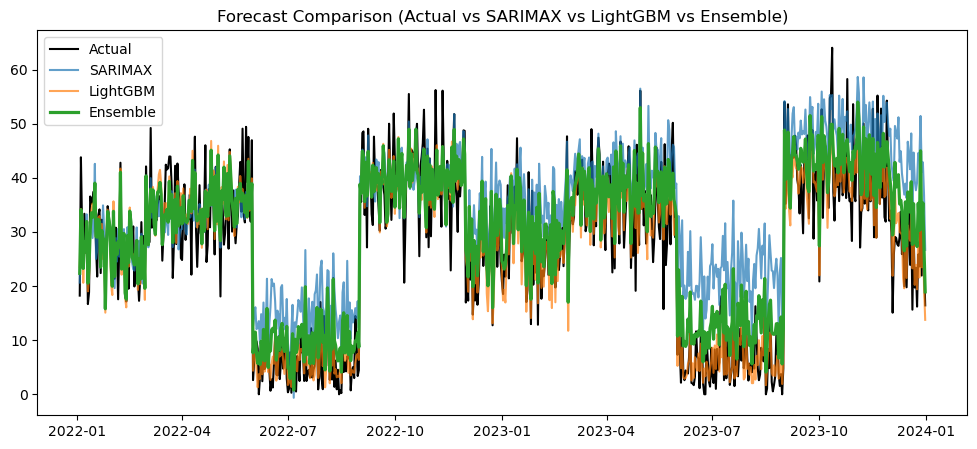

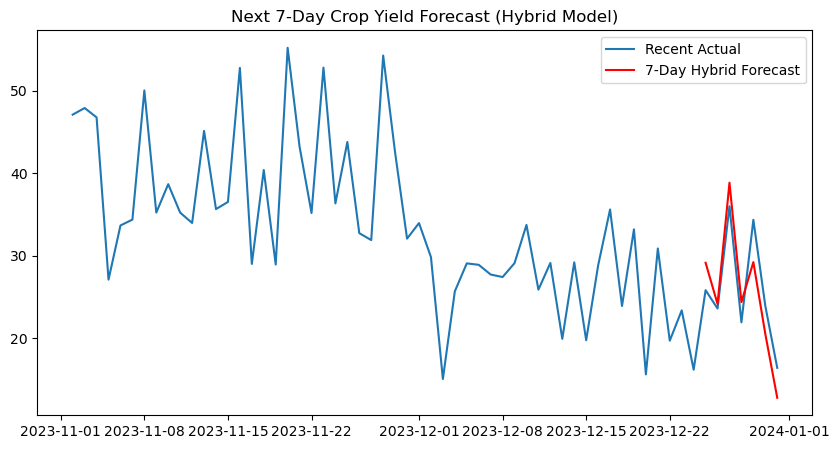

Next 7-day forecast:
2023-12-25    29.152689
2023-12-26    24.161889
2023-12-27    38.851063
2023-12-28    24.391778
2023-12-29    29.233794
2023-12-30    20.532184
2023-12-31    12.800651
Freq: D, dtype: float64


In [19]:
# ==============================================================
# ✅ HYBRID FORECASTING (SARIMAX + LightGBM Ensemble) – FIXED & 7-DAY
# ==============================================================

import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# --- Data Prep ---
target_col = "Crop_Yield"
exog_cols = ["Temperature", "Humidity", "N", "P", "K"]

y = df_reg[target_col].interpolate(method="time").ffill().bfill()
X_exog = df_reg[exog_cols].interpolate(method="time").ffill().bfill()

# --- Lag & Rolling Features ---
def create_lag_features(df, col, lags=[1,2,3,7,14], roll_windows=[3,7,14]):
    feats = pd.DataFrame(index=df.index)
    for lag in lags:
        feats[f"{col}_lag{lag}"] = df[col].shift(lag)
    for w in roll_windows:
        feats[f"{col}_rollmean{w}"] = df[col].shift(1).rolling(window=w).mean()
        feats[f"{col}_rollstd{w}"] = df[col].shift(1).rolling(window=w).std()
    return feats

lag_feats = create_lag_features(df_reg, target_col)
X_full = pd.concat([X_exog, lag_feats], axis=1).dropna()
y_full = y.loc[X_full.index]

# --- Train/Test Split ---
split = int(len(X_full) * 0.8)
X_train, X_test = X_full.iloc[:split], X_full.iloc[split:]
y_train, y_test = y_full.iloc[:split], y_full.iloc[split:]

# --- Scale Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Train LightGBM ---
lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.03,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgb_model.fit(X_train_scaled, y_train)

# --- Predictions ---
y_pred_lgb = lgb_model.predict(X_test_scaled)
y_pred_sarimax = pred.reindex(y_test.index, method="nearest")

# --- Ensemble ---
ensemble_pred = 0.6 * y_pred_lgb + 0.4 * y_pred_sarimax.values

# --- Evaluation ---
mae_sarimax = mean_absolute_error(y_test, y_pred_sarimax)
rmse_sarimax = mean_squared_error(y_test, y_pred_sarimax, squared=False)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
rmse_lgb = mean_squared_error(y_test, y_pred_lgb, squared=False)
mae_ensemble = mean_absolute_error(y_test, ensemble_pred)
rmse_ensemble = mean_squared_error(y_test, ensemble_pred, squared=False)

print(f"SARIMAX -> MAE: {mae_sarimax:.3f}, RMSE: {rmse_sarimax:.3f}")
print(f"LightGBM -> MAE: {mae_lgb:.3f}, RMSE: {rmse_lgb:.3f}")
print(f"Ensemble -> MAE: {mae_ensemble:.3f}, RMSE: {rmse_ensemble:.3f}")

# --- Plot Comparison ---
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label="Actual", color="black")
plt.plot(y_test.index, y_pred_sarimax, label="SARIMAX", alpha=0.7)
plt.plot(y_test.index, y_pred_lgb, label="LightGBM", alpha=0.7)
plt.plot(y_test.index, ensemble_pred, label="Ensemble", linewidth=2.3)
plt.title("Forecast Comparison (Actual vs SARIMAX vs LightGBM vs Ensemble)")
plt.legend()
plt.show()

# ==============================================================
# ✅ 7-DAY FUTURE FORECAST
# ==============================================================

future_steps = 7

# Rebuild full feature set with lags for the latest data
lag_feats_future = create_lag_features(df_reg, target_col)
future_full = pd.concat([X_exog, lag_feats_future], axis=1).dropna()

# Take the most recent rows (simulate last observed window)
future_X = future_full.iloc[-future_steps:]

# Scale using the same scaler
future_X_scaled = scaler.transform(future_X)

# Predict using LightGBM and SARIMAX
future_pred_lgb = lgb_model.predict(future_X_scaled)
future_pred_sarimax = res.get_forecast(steps=future_steps, exog=future_X[exog_cols]).predicted_mean

# Ensemble
future_pred = 0.6 * future_pred_lgb + 0.4 * future_pred_sarimax.values

# --- Plot 7-Day Forecast ---
plt.figure(figsize=(10,5))
plt.plot(y_full.index[-60:], y_full[-60:], label="Recent Actual")
plt.plot(future_X.index, future_pred, label="7-Day Hybrid Forecast", color="red")
plt.title("Next 7-Day Crop Yield Forecast (Hybrid Model)")
plt.legend()
plt.show()

print("Next 7-day forecast:")
print(pd.Series(future_pred, index=future_X.index))


In [20]:
# ==========================================================
# 💾 SAVE TRAINED HYBRID MODEL FOR FASTAPI DEPLOYMENT
# ==========================================================
import joblib

# Bundle everything needed for prediction
model_bundle = {
    "sarimax": res,                   # your trained SARIMAX model
    "lgb": lgb_model,                 # your trained LightGBM model
    "scaler": scaler,                 # the fitted StandardScaler
    "exog_cols": ["Temperature", "Humidity", "N", "P", "K"],
    "target_col": "Crop_Yield"
}

joblib.dump(model_bundle, "hybrid_model.joblib")
print("✅ Saved: hybrid_model.joblib")

# Optional sanity check: load it back and test
test_bundle = joblib.load("hybrid_model.joblib")
print("🔍 Loaded successfully! Contains keys:", list(test_bundle.keys()))


✅ Saved: hybrid_model.joblib
🔍 Loaded successfully! Contains keys: ['sarimax', 'lgb', 'scaler', 'exog_cols', 'target_col']
